In [24]:
import os
import json
import cv2
import numpy as np
from hydra import initialize, compose
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pyclipper
import torch

from runners import predict
from ocr.datasets.base import OCRDataset

In [17]:
device = torch.device("cuda")

In [25]:
datasets = OCRDataset("/data/datasets/images/val")

TypeError: OCRDataset.__init__() missing 2 required positional arguments: 'annotation_path' and 'transform'

In [20]:
#@title DBNet 데이터 전처리

# Albumentations 변환 정의 : 입력 사이즈 변환 및 Padding, Normalize, Tensor변환
transform = A.Compose([
    A.LongestMaxSize(max_size=640, p=1.0),
    A.PadIfNeeded(min_width=640, min_height=640, border_mode=0, p=1.0),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])


# 줄어든 이미지 사이즈를 입력 이미지 사이즈로 복원하기 위한 Inverse Matrix를 계산
def calculate_inverse_transform(original_size, transformed_size, crop_box=None):
    ox, oy = original_size
    tx, ty = transformed_size
    cx, cy = 0, 0
    if crop_box:
        cx, cy, tx, ty = crop_box

    # Scale back to the original size
    scale_x = ox / tx
    scale_y = oy / ty
    scale_matrix = np.array([
        [scale_x, 0, 0],
        [0, scale_y, 0],
        [0, 0, 1]
    ])

    # Padding back to the original size
    translation_matrix = np.eye(3)
    translation_matrix[0, 2] = -cx
    translation_matrix[1, 2] = -cy

    # 하나의 매트릭스로 역변환 할 수 있도록 두 매트릭스를 결합
    inverse_matrix = np.dot(scale_matrix, translation_matrix)
    return inverse_matrix


# 변환된 이미지의 Size 및 Padding 크기 계산
def calculate_cropbox(original_size, target_size=640):
    ox, oy = original_size
    scale = target_size / max(ox, oy)
    new_width, new_height = int(ox * scale), int(oy * scale)
    delta_w = target_size - new_width
    delta_h = target_size - new_height
    x, y = delta_w // 2, delta_h // 2
    w, h = new_width, new_height
    return x, y, w, h


# 테스트 이미지 준비 과정
batch = []
for image in test_images:
    data = dict()
    transformed = transform(image=image)                        # 이미지 Transform
    transformed_image = transformed["image"]
    data['images'] = transformed_image.unsqueeze(0).to(device)  # 모델 추론을 위한 변환된 이미지 저장
    data['origin_images'] = [image]                             # Visualization을 위한 원본 이미지 저장

    # 추론 결과를 원본 이미지 크기로 변환하기 위한 Inverse Matrix 저장
    height, width, _ = image.shape
    _, new_height, new_width = transformed_image.shape
    crop_box = calculate_cropbox((width, height), max(new_height, new_width))
    inverse_matrix = calculate_inverse_transform((width, height),
                                                 (new_width, new_height),
                                                 crop_box=crop_box)
    data['inverse_matrix'] = [inverse_matrix]

    batch.append(data)

TypeError: image must be numpy array type

In [2]:
with initialize(config_path="configs"):
    cfg = compose("predict.yaml")

/tmp/ipykernel_268857/226645267.py:1: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path="configs"):


In [3]:
temp = predict.predict(cfg)

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at ./outputs/ocr_training_2024-04-25_11-00-48/checkpoints/epoch=7-step=18552.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./outputs/ocr_training_2024-04-25_11-00-48/checkpoints/epoch=7-step=18552.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

In [4]:
temp[0].keys()

odict_keys(['prob_maps'])

In [5]:
temp[0]['prob_maps']

tensor([[[[0.0002, 0.0002, 0.0003,  ..., 0.0012, 0.0007, 0.0006],
          [0.0002, 0.0003, 0.0003,  ..., 0.0007, 0.0005, 0.0005],
          [0.0003, 0.0003, 0.0004,  ..., 0.0011, 0.0009, 0.0011],
          ...,
          [0.0005, 0.0005, 0.0004,  ..., 0.0007, 0.0008, 0.0011],
          [0.0005, 0.0006, 0.0005,  ..., 0.0012, 0.0009, 0.0009],
          [0.0004, 0.0005, 0.0005,  ..., 0.0029, 0.0008, 0.0009]]]])

In [9]:
temp[0]['prob_maps'].shape

torch.Size([1, 1, 640, 640])

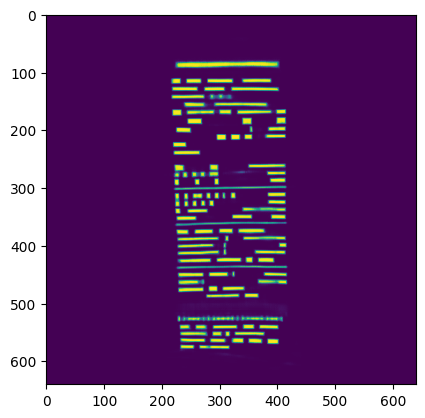

In [11]:
plt.imshow(temp[0]['prob_maps'].squeeze(0).detach().cpu().squeeze(0))

In [6]:
#@title 추론 결과 후처리를 위한 Class

class DBPostProcessor:
    def __init__(self, thresh=0.3, box_thresh=0.4, max_candidates=300, use_polygon=False):
        self.min_size = 3                       # 텍스트 검출 최소 사이즈
        self.thresh = thresh                    # 모델의 출력 결과 Segmentation map을 Binarization 하기 위한 Threshold
        self.box_thresh = box_thresh            # 텍스트 영역 판정을 위한 Threshold
        self.max_candidates = max_candidates    # 최대 텍스트 검출 후보 영역의 갯수
        self.use_polygon = use_polygon          # Polygon 검출을 할지 Quad 검출을 할지에 대한 Type flag

    # Segmentation map 결과로부터 텍스트 영역의 좌표를 반환하는 메소드
    def represent(self, batch, _pred):
        """
        batch: a dict produced by dataloaders.
            images: tensor of shape (N, C, H, W).
            polygons: tensor of shape (N, K, 4, 2), the polygons of objective regions.
            ignore_tags: tensor of shape (N, K), indicates whether a region is ignorable or not.
            shape: the original shape of images.
            inverse_matrix: Warp Perspective Matrix, with shape (3, 3) as NDArray[float32]
            filename: the original filenames of images.
        pred:
            prob_maps: text region segmentation map, with shape (N, 1, H, W)
        """
        assert 'images' in batch is not None, "images is required in batch"
        images = batch['images']

        # Use prob_maps if pred is a dict
        if isinstance(_pred, dict):
            assert 'prob_maps' in _pred is not None, "prob_maps is required in _pred"
            pred = _pred['prob_maps']
        else:
            pred = _pred

        assert 'inverse_matrix' in batch is not None, "inverse_matrix is required in batch"
        inverse_matrix = batch['inverse_matrix']

        # Probability map을 이진화
        segmentation = self.binarize(pred)

        boxes_batch = []
        scores_batch = []
        for batch_index in range(images.size(0)):
            if self.use_polygon:
                # Get polygons from segmentation
                boxes, scores = self.polygons_from_bitmap(
                                        pred[batch_index],
                                        segmentation[batch_index],
                                        inverse_matrix=inverse_matrix[batch_index])
            else:
                # Get boxes from segmentation
                boxes, scores = self.boxes_from_bitmap(
                                        pred[batch_index],
                                        segmentation[batch_index],
                                        inverse_matrix=inverse_matrix[batch_index])
            # Append to batch
            boxes_batch.append(boxes)
            scores_batch.append(scores)

        return boxes_batch, scores_batch

    @staticmethod
    # Inverse matrix를 이용하여 원본 이미지에 대한 좌표로 변환 하는 메소드
    def __transform_coordinates(coords, matrix):
        """
        Transform coordinates according to the warp matrix

        coords: (N, 2) as NDArray[float32]
        matrix: (3, 3) as NDArray[float32]
        return: (N, 2) as NDArray[float32]
        """
        coords = np.array(coords)
        coords = np.dot(matrix, np.vstack([coords.T, np.ones(coords.shape[0])]))
        coords /= coords[2, :]
        return coords.T[:, :2]

    # Binarize the prediction
    def binarize(self, pred):
        # 후처리 과정에서 단일 Threshold를 사용하여 이진화
        return pred > torch.Tensor([self.thresh]).to(device=pred.device)

    # 추론 결과 영역에서 텍스트 영역을 검출하여 반환하는 메소드 (Polygon으로 추출할때)
    def polygons_from_bitmap(self, pred, _bitmap,
                             inverse_matrix=None):
        """
        Extracts polygons and their scores from a bitmap image.

        _bitmap: single map with shape (1, H, W),
            whose values are binarized as {0, 1}
        """

        assert _bitmap.size(0) == 1
        bitmap = _bitmap.cpu().numpy()[0]  # The first channel
        pred = pred.cpu().detach().numpy()[0]

        boxes = []
        scores = []

        # 컨투어 영역 찾기
        # Find contours from the binarized map
        # contours: a list of contours
        # https://docs.opencv.org/4.9.0/d4/d73/tutorial_py_contours_begin.html
        contours, _ = cv2.findContours(
            (bitmap * 255).astype(np.uint8),
            cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

        # 최대 텍스트 검출 후보 영역의 갯수만큼 컨투어 영역이 텍스트 영역인지 판단
        # Get the top N contours
        for contour in contours[:self.max_candidates]:
            # 복잡한 컨투어 픽셀을 근사화하여 영역 다듬기
            # Approximate the contour with Douglas-Peucker algorithm
            # https://docs.opencv.org/4.9.0/dc/dcf/tutorial_js_contour_features.html
            epsilon = 0.002 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)
            points = approx.reshape((-1, 2))
            # 최소 포인트가 4개 미만인 경우 무시
            if points.shape[0] < 4:
                continue

            # 컨투어 영역에서 텍스트가 차지하는 영역에 대한 점수 계산
            # Get the score of the box
            score = self.box_score_fast(pred, points.reshape(-1, 2))
            if self.box_thresh > score:
                continue

            # Shrink되어있는 추론 결과를 다시 Dilate하는 과정
            # Unclip the box
            if points.shape[0] > 2:
                box = self.unclip(points, unclip_ratio=2.0)
                if box is None:
                    continue
            else:
                continue

            # 주어진 영역의 크기를 구하고 최소 사이즈 미만의 경우 무시
            # Get the mini box
            box = box.reshape(-1, 2)
            _, sside = self.get_mini_boxes(box.reshape((-1, 1, 2)))
            if sside < self.min_size + 2:
                continue

            # Inverse Matrix를 이용하여 원본 이미지의 위치로 좌표 변환
            # Transform the coordinates
            box = self.__transform_coordinates(box, inverse_matrix)

            # Append to the list
            boxes.append(np.round(box).astype(np.int16).tolist())
            scores.append(score)

        return boxes, scores

    # 추론 결과 영역에서 텍스트 영역을 검출하여 반환하는 메소드 (QuadBox로 추출할때)
    # 텍스트 영역을 찾는 과정을 제외하고 Polygon과 동일
    def boxes_from_bitmap(self, pred, _bitmap,
                          inverse_matrix=None):
        """
        Extracts bounding boxes and their scores from a bitmap image.

        _bitmap: single map with shape (1, H, W),
            whose values are binarized as {0, 1}
        """

        assert _bitmap.size(0) == 1
        bitmap = _bitmap.cpu().numpy()[0]  # The first channel
        pred = pred.cpu().detach().numpy()[0]

        boxes = []
        scores = []

        # 컨투어 영역 찾기
        # Find contours from the binarized map
        # contours: a list of contours
        # https://docs.opencv.org/4.9.0/d4/d73/tutorial_py_contours_begin.html
        contours, _ = cv2.findContours(
            (bitmap * 255).astype(np.uint8),
            cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        num_contours = min(len(contours), self.max_candidates)

        # 최대 텍스트 검출 후보 영역의 갯수만큼 컨투어 영역이 텍스트 영역인지 판단
        # Get the top N contours
        for index in range(num_contours):
            # 컨투어 영역의 좌표와 크기를 구하고 최소 사이즈 이하의 경우 무시
            # Get the mini box
            contour = contours[index]
            points, sside = self.get_mini_boxes(contour)
            if sside < self.min_size:
                continue

            # 컨투어 영역에서 텍스트가 차지하는 영역에 대한 점수 계산
            # Get the score of the box
            points = np.array(points)
            score = self.box_score_fast(pred, points.reshape(-1, 2))
            if self.box_thresh > score:
                continue

            # Shrink되어있는 추론 결과를 다시 Dilate하는 과정
            # Unclip the box
            box = self.unclip(points).reshape(-1, 1, 2)
            box, sside = self.get_mini_boxes(box)
            if sside < self.min_size + 2:
                continue
            box = np.array(box)

            # Inverse Matrix를 이용하여 원본 이미지의 위치로 좌표 변환
            # Transform the coordinates
            box = self.__transform_coordinates(box, inverse_matrix)

            # Append to the list
            boxes.append(np.round(box).astype(np.int16).tolist())
            scores.append(score)

        return boxes, scores

    def unclip(self, box, unclip_ratio=1.5):
        """
        Expands the given box by a specified ratio.

        box: a list of points of shape (N, 2)
        unclip_ratio: the ratio of unclipping the box
        return: a list of points of shape (N, 2)
        """

        # transform the box to polygon
        poly = Polygon(box)
        if poly.area == 0 or poly.length == 0:
            return None

        # get the expanded polygon
        # unclip_ratio의 비율로 확대된 Distance를 구하고 영역을 확장함
        distance = poly.area * unclip_ratio / poly.length
        offset = pyclipper.PyclipperOffset()
        offset.AddPath(box, pyclipper.JT_ROUND, pyclipper.ET_CLOSEDPOLYGON)
        expanded = np.array(offset.Execute(distance)[0])

        return expanded

    def get_mini_boxes(self, contour):
        """
        Converts a contour into its minimum area bounding box.

        contour: a list of points of shape (N, 1, 2)
        return: a list of points of shape (N, 2)
        """

        # Get the bounding box
        # https://docs.opencv.org/4.9.0/de/d62/tutorial_bounding_rotated_ellipses.html
        bounding_box = cv2.minAreaRect(contour)
        points = sorted(list(cv2.boxPoints(bounding_box)), key=lambda x: x[0])

        index_1, index_2, index_3, index_4 = 0, 1, 2, 3
        if points[1][1] > points[0][1]:
            index_1 = 0
            index_4 = 1
        else:
            index_1 = 1
            index_4 = 0
        if points[3][1] > points[2][1]:
            index_2 = 2
            index_3 = 3
        else:
            index_2 = 3
            index_3 = 2

        box = [points[index_1], points[index_2],
               points[index_3], points[index_4]]
        return box, min(bounding_box[1])

    def box_score_fast(self, bitmap, _box):
        """
        Calculates a score for a box in a bitmap.
        The score is the percentage of the box area that overlaps with
        the highlighted areas (marked as 1) in the bitmap.

        bitmap: a single map with shape (H, W), whose values are binarized as {0, 1}
        _box: a list of points of shape (N, 2)
        return: a score of the box as float32
        """

        h, w = bitmap.shape[:2]
        box = _box.copy()
        xmin = np.clip(np.floor(box[:, 0].min()).astype(np.int32), 0, w - 1)
        xmax = np.clip(np.ceil(box[:, 0].max()).astype(np.int32), 0, w - 1)
        ymin = np.clip(np.floor(box[:, 1].min()).astype(np.int32), 0, h - 1)
        ymax = np.clip(np.ceil(box[:, 1].max()).astype(np.int32), 0, h - 1)

        mask = np.zeros((ymax - ymin + 1, xmax - xmin + 1), dtype=np.uint8)
        box[:, 0] = box[:, 0] - xmin
        box[:, 1] = box[:, 1] - ymin

        cv2.fillPoly(mask, box.reshape(1, -1, 2).astype(np.int32), 1)

        return cv2.mean(bitmap[ymin:ymax + 1, xmin:xmax + 1], mask)[0]